In [125]:
# torch and libs
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# own modules
from PixelCNN import PixelCNN
from GAN_descriminator import ConvDescriminator
from ResNetGenerator import Generator
from ResNetDescriminator import Discriminator

# utils
from torchvision.datasets import CIFAR10, CIFAR100
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from time import time

from typing import Callable, Optional

# global vars
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

### Generative model

Как дескриминатор и генератор использую сверточную сеть с пробросом градинета. Т.е. ResNet блоки. Реализацию взял из имплементации в torch [https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L684]

In [126]:
class ResNetUpConvBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 3,
        stride: int = 1,
        padding: int = 1,
        reshaper: Optional[Callable] = None,
    ):
        super().__init__()

        self.conv1 = nn.ConvTranspose2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=1,
        )
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)

        self.conv2 = nn.ConvTranspose2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        )
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)

        self.conv3 = nn.ConvTranspose2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=1,
        )
        self.bn3 = nn.BatchNorm2d(num_features=out_channels)

        self.reshaper = reshaper

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += x if self.reshaper is None else self.reshaper(x)
        out = self.relu(out)

        return out


class Generator(nn.Module):
    def __init__(self, noise_dim, output_shape, block_count: int = 10):
        super().__init__()
        self.noise_dim = noise_dim
        self.output_shape = output_shape

        self.base_size = (int(64 * 2 ** (block_count // 2 - 1)), output_shape[1] // 2 ** (
            block_count // 2), output_shape[2] // 2 ** (block_count // 2))

        self.linear = nn.Linear(in_features=noise_dim, out_features=64 *
                                output_shape[1] * output_shape[2] // 2 ** (block_count // 2 + 1))

        channels_num = 64 * 2 ** (block_count // 2 - 1)
        self.blocks = []

        for i in range(block_count):
            if i % 2 == 0 and i:
                channels_num //= 2

                reshaper = nn.Sequential(
                    nn.ConvTranspose2d(
                        in_channels=channels_num * 2,
                        out_channels=channels_num,
                        kernel_size=2,
                        stride=2,
                    ),
                    nn.BatchNorm2d(num_features=channels_num)
                )
                block = ResNetUpConvBlock(
                    channels_num * 2,
                    channels_num,
                    kernel_size=2,
                    stride=2,
                    padding=0,
                    reshaper=reshaper,
                )
            else:
                block = ResNetUpConvBlock(channels_num, channels_num)

            self.blocks.append(block)

        self.blocks = nn.ModuleList(self.blocks)

        # now shape is (64, output_shape[0] // 2, output_shape[1] // 2)
        self.up_conv = nn.ConvTranspose2d(
            in_channels=channels_num,
            out_channels=self.output_shape[0],
            kernel_size=2,
            stride=2,
        )

    def forward(self, z):
        out = self.linear(z)
        out = out.reshape(-1, *self.base_size)

        for i, block in enumerate(self.blocks):
            out = block(out)

        out = self.up_conv(out)
        out = nn.functional.sigmoid(out)

        return out


In [127]:

class ResNetConvBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        stride: int = 1,
        reshaper: Optional[Callable] = None,
    ):
        super(ResNetConvBlock, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=1,
        )
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)

        self.conv2 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
        )
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)

        self.conv3 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=1,
        )
        self.bn3 = nn.BatchNorm2d(num_features=out_channels)

        self.reshaper = reshaper

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += x if self.reshaper is None else self.reshaper(x)
        out = self.relu(out)

        return out

class Discriminator(nn.Module):
    def __init__(self, input_shape, block_count: int = 4):
        super().__init__()
        self.input_shape = input_shape

        channels_num = 32
        self.blocks = []

        for i in range(block_count):
            if i % 2 == 0:
                channels_num *= 2

                reshaper = nn.Sequential(
                    nn.Conv2d(
                        in_channels=channels_num // 2 if i else self.input_shape[0],
                        out_channels=channels_num,
                        kernel_size=1,
                        stride=2,
                    ),
                    nn.BatchNorm2d(num_features=channels_num)
                )
                block = ResNetConvBlock(
                    channels_num // 2 if i else self.input_shape[0],
                    channels_num,
                    stride=2,
                    reshaper=reshaper,
                )
            else:
                block = ResNetConvBlock(channels_num, channels_num)

            self.blocks.append(block)

        self.blocks = nn.ModuleList(self.blocks)

        self.linear = nn.Linear(
            in_features=self.input_shape[1] * self.input_shape[2] * 2 ** (5 - block_count // 2), 
            out_features=1,
            )
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = x

        for i, block in enumerate(self.blocks):
            out = block(out)

        out = out.reshape(-1, self.linear.in_features)
        out = self.linear(out)

        out = self.sigmoid(out)

        return out

In [128]:
class GAN(nn.Module):
    def __init__(self, input_shape, batch_size, 
                 noise_fn, data_fn,
                 lr_D=1e-3, lr_G=2e-4,
                 noise_dim = 128,
                 flw = 1):
        """
        GAN 
        Args:
        input_shape: d
        noise_fn: function that generate latent vector :pytorch Tensor
        
        """
        super().__init__()
        self.batch_size = batch_size

        self.noise_fn = noise_fn
        self.data_fn = data_fn
        self.noise_dim = noise_dim
        self.flw = flw

        # Generator and Discriminator
        self.generator = Generator(noise_dim, input_shape, block_count=10)
        self.discriminator = Discriminator(input_shape, block_count=2)

        self.optim_D = optim.Adam(self.generator.parameters(),
                                  lr=lr_D)
        self.optim_G = optim.Adam(self.discriminator.parameters(),
                                  lr=lr_G)

        self.target_ones = torch.ones((batch_size, 1)).to(device)
        self.target_zeros = torch.zeros((batch_size, 1)).to(device)
        self.criterion = nn.BCELoss()
    
    def train_step_G(self):
        """Train the generator one step and return the loss."""
        self.generator.zero_grad()
   
        latent_vector = self.noise_fn(self.batch_size, self.noise_dim)
        generated = self.generator(latent_vector)
        classifications = self.discriminator(generated).to(device)

        loss = self.criterion(classifications, self.target_ones)
        loss.backward()
        self.optim_G.step()
        return loss.item()

    def train_step_D(self):
        """Train the discriminator one step and return the losses."""
        self.discriminator.zero_grad()

        # real samples
        real_samples = self.data_fn(self.batch_size)
        # calc real loss
        pred_real = self.discriminator(real_samples).to(device)
        loss_real = self.criterion(pred_real, self.target_ones)

        # generated samples
        latent_vector = self.noise_fn(self.batch_size, self.noise_dim)
        # calc fake loss
        with torch.no_grad():
            fake_samples = self.generator(latent_vector)
        
        pred_fake = self.discriminator(fake_samples).to(device)
        loss_fake = self.criterion(pred_fake, self.target_zeros)

        # combine with constant flw
        loss = (loss_real + self.flw * loss_fake) / 2
        loss.backward()
        self.optim_D.step()
        
        return loss_real.item(), loss_fake.item()
    
    def train_step(self):
        """Train both networks and return the losses."""
        loss_D = self.train_step_D()
        loss_G = self.train_step_G()
        return loss_G, loss_D
    
     
    def generate_samples(self, num=None, latent_vector=None):
        """Sample from the generator.
        Args:
            num: The number of samples to generate if latent_vec is None
        If latent_vec and num are None then us self.batch_size random latent
        vectors.
        ! We don't need grad for generated samples
        """
        num = self.batch_size if num is None else num
        latent_vector = self.noise_fn(num) if latent_vector is None else latent_vector
        with torch.no_grad():
            samples = self.generator(latent_vector)
        return samples

Функция чтобы просматривать картинки

In [129]:
def imshow(imgs):
    img = make_grid(imgs)
    npimg = img.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def visualize_GAN(gan:GAN):
    imshow(gan.generate_samples(num=3))

Константы

In [130]:
BATCH_SIZE = 512
EPOCHS = 100

База данных

In [131]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = CIFAR10('../data/', train=True, transform=transform, download=True)
test_dataset = CIFAR10('../data/', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Функции для получения латентных векторов для генератора и реальных семплов.

In [132]:
def make_data_fn(train_loader=train_loader):
    iterator = iter(train_loader)
    
    def wrapper(batch_size):
        nonlocal iterator
        try:
            batch = next(iterator)[0]
        except:
            iterator = iter(train_loader)
            batch = next(iterator)[0]
        assert len(batch) == batch_size
        return batch.to(device)
    
    return wrapper

def noise_fn(batch_size, latent_vec_size=128):
    return torch.rand((batch_size, latent_vec_size)).to(device)

train model

In [133]:
gan = GAN(input_shape=(3, 32, 32), batch_size=BATCH_SIZE, 
          noise_fn=noise_fn,
          data_fn=make_data_fn(),
          noise_dim=128,
          flw=1).to(device)

/home/kamil/.local/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 1/100 (3s): G=0.056, Dr=1.048, Df=1.475


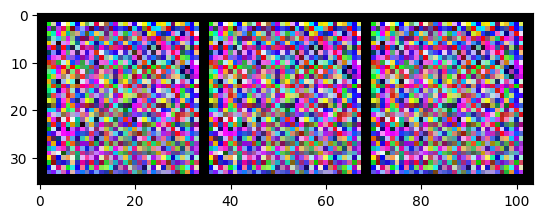

Epoch 2/100 (7s): G=0.075, Dr=0.451, Df=0.734
Epoch 3/100 (10s): G=0.156, Dr=0.233, Df=0.827
Epoch 4/100 (14s): G=0.287, Dr=0.125, Df=1.615
Epoch 5/100 (18s): G=0.279, Dr=0.080, Df=1.525
Epoch 6/100 (21s): G=0.304, Dr=0.069, Df=1.468


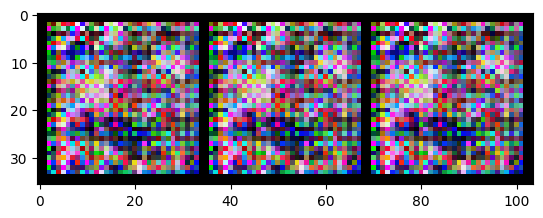

Epoch 7/100 (25s): G=0.280, Dr=0.110, Df=1.486
Epoch 8/100 (28s): G=0.262, Dr=0.116, Df=1.304
Epoch 9/100 (32s): G=0.275, Dr=0.109, Df=1.215
Epoch 10/100 (36s): G=0.264, Dr=0.168, Df=1.536
Epoch 11/100 (39s): G=0.251, Dr=0.428, Df=1.540


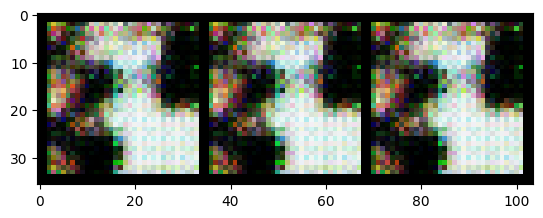

Epoch 12/100 (43s): G=0.279, Dr=0.476, Df=2.049
Epoch 13/100 (46s): G=0.248, Dr=0.467, Df=1.893
Epoch 14/100 (50s): G=0.301, Dr=0.228, Df=1.961
Epoch 15/100 (54s): G=0.293, Dr=0.212, Df=1.699
Epoch 16/100 (57s): G=0.277, Dr=0.161, Df=1.843


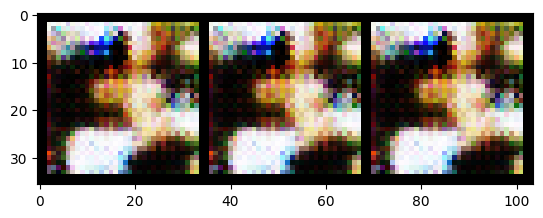

Epoch 17/100 (61s): G=0.254, Dr=0.205, Df=1.471
Epoch 18/100 (64s): G=0.245, Dr=0.274, Df=1.484
Epoch 19/100 (68s): G=0.264, Dr=0.256, Df=1.762
Epoch 20/100 (72s): G=0.274, Dr=0.210, Df=1.665
Epoch 21/100 (75s): G=0.258, Dr=0.187, Df=1.444


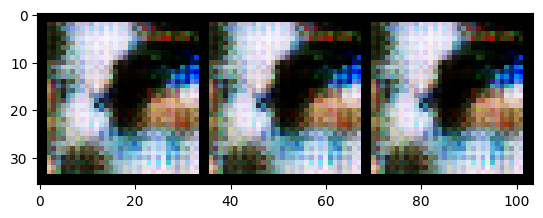

Epoch 22/100 (79s): G=0.269, Dr=0.240, Df=1.487
Epoch 23/100 (83s): G=0.278, Dr=0.191, Df=1.754
Epoch 24/100 (86s): G=0.262, Dr=0.323, Df=1.710
Epoch 25/100 (90s): G=0.265, Dr=0.262, Df=1.720
Epoch 26/100 (94s): G=0.263, Dr=0.216, Df=1.712


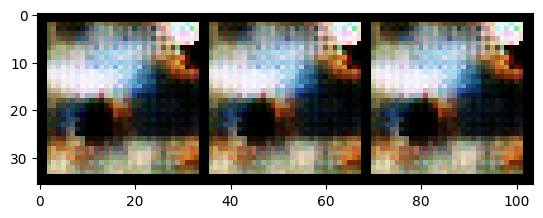

Epoch 27/100 (97s): G=0.268, Dr=0.136, Df=1.580
Epoch 28/100 (101s): G=0.274, Dr=0.093, Df=1.515
Epoch 29/100 (105s): G=0.273, Dr=0.122, Df=1.472
Epoch 30/100 (108s): G=0.263, Dr=0.225, Df=1.360
Epoch 31/100 (112s): G=0.295, Dr=0.140, Df=1.767


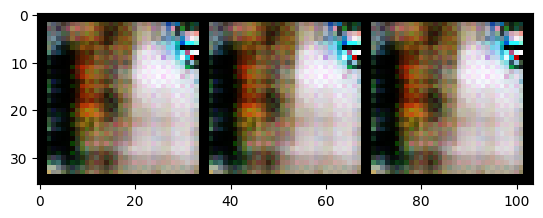

Epoch 32/100 (116s): G=0.266, Dr=0.201, Df=1.559
Epoch 33/100 (119s): G=0.258, Dr=0.181, Df=1.492
Epoch 34/100 (123s): G=0.270, Dr=0.155, Df=1.568
Epoch 35/100 (127s): G=0.232, Dr=0.249, Df=1.529
Epoch 36/100 (130s): G=0.307, Dr=0.123, Df=1.728


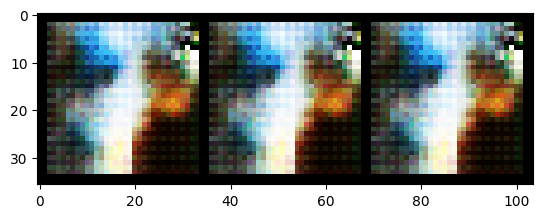

Epoch 37/100 (134s): G=0.299, Dr=0.101, Df=1.841
Epoch 38/100 (138s): G=0.264, Dr=0.125, Df=1.366
Epoch 39/100 (141s): G=0.273, Dr=0.162, Df=1.408
Epoch 40/100 (145s): G=0.247, Dr=0.176, Df=1.291
Epoch 41/100 (149s): G=0.269, Dr=0.146, Df=1.525


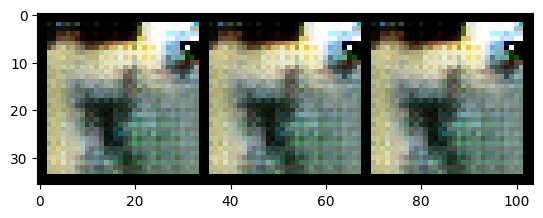

Epoch 42/100 (153s): G=0.285, Dr=0.058, Df=1.440
Epoch 43/100 (156s): G=0.270, Dr=0.071, Df=1.378
Epoch 44/100 (160s): G=0.280, Dr=0.064, Df=1.457
Epoch 45/100 (164s): G=0.292, Dr=0.057, Df=1.470
Epoch 46/100 (167s): G=0.259, Dr=0.099, Df=1.345


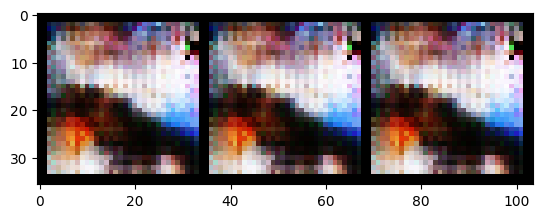

Epoch 47/100 (171s): G=0.279, Dr=0.098, Df=1.340
Epoch 48/100 (174s): G=0.267, Dr=0.095, Df=1.426
Epoch 49/100 (178s): G=0.244, Dr=0.160, Df=1.319
Epoch 50/100 (182s): G=0.229, Dr=0.285, Df=1.277
Epoch 51/100 (185s): G=0.300, Dr=0.144, Df=1.522


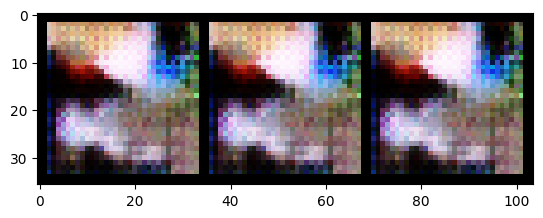

Epoch 52/100 (189s): G=0.288, Dr=0.085, Df=1.676
Epoch 53/100 (193s): G=0.305, Dr=0.072, Df=1.667
Epoch 54/100 (196s): G=0.268, Dr=0.143, Df=1.504
Epoch 55/100 (200s): G=0.272, Dr=0.146, Df=1.569
Epoch 56/100 (204s): G=0.292, Dr=0.161, Df=1.722


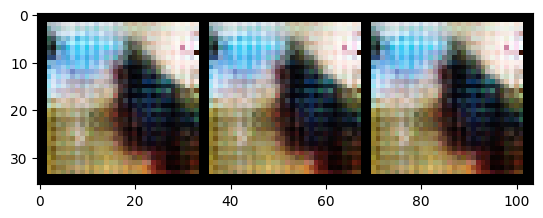

Epoch 57/100 (207s): G=0.298, Dr=0.146, Df=2.135
Epoch 58/100 (211s): G=0.293, Dr=0.163, Df=1.974
Epoch 59/100 (215s): G=0.274, Dr=0.170, Df=1.652
Epoch 60/100 (218s): G=0.299, Dr=0.102, Df=1.505
Epoch 61/100 (222s): G=0.284, Dr=0.056, Df=1.551


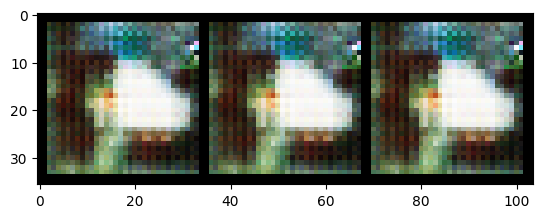

Epoch 62/100 (226s): G=0.259, Dr=0.082, Df=1.379
Epoch 63/100 (229s): G=0.253, Dr=0.137, Df=1.322
Epoch 64/100 (233s): G=0.268, Dr=0.101, Df=1.426
Epoch 65/100 (236s): G=0.239, Dr=0.227, Df=1.341
Epoch 66/100 (240s): G=0.259, Dr=0.195, Df=1.357


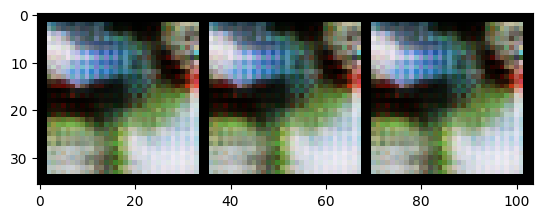

Epoch 67/100 (244s): G=0.294, Dr=0.102, Df=1.619
Epoch 68/100 (247s): G=0.261, Dr=0.173, Df=1.555
Epoch 69/100 (251s): G=0.269, Dr=0.137, Df=1.646
Epoch 70/100 (255s): G=0.280, Dr=0.112, Df=1.381
Epoch 71/100 (258s): G=0.275, Dr=0.104, Df=1.538


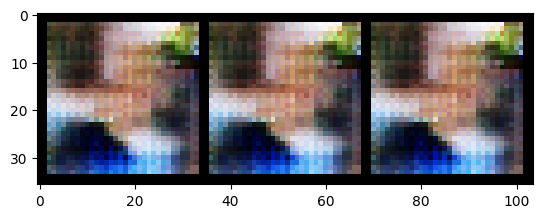

Epoch 72/100 (262s): G=0.277, Dr=0.079, Df=1.535
Epoch 73/100 (266s): G=0.284, Dr=0.092, Df=1.535
Epoch 74/100 (269s): G=0.274, Dr=0.095, Df=1.553
Epoch 75/100 (273s): G=0.268, Dr=0.081, Df=1.382
Epoch 76/100 (276s): G=0.302, Dr=0.069, Df=1.529


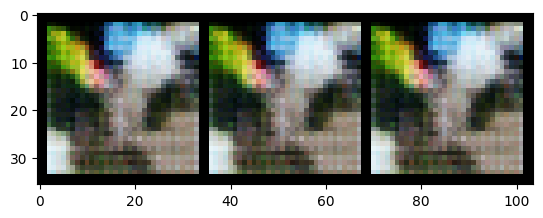

Epoch 77/100 (280s): G=0.269, Dr=0.074, Df=1.491
Epoch 78/100 (284s): G=0.275, Dr=0.106, Df=1.438
Epoch 79/100 (288s): G=0.280, Dr=0.106, Df=1.556
Epoch 80/100 (291s): G=0.287, Dr=0.103, Df=1.669
Epoch 81/100 (295s): G=0.309, Dr=0.086, Df=1.607


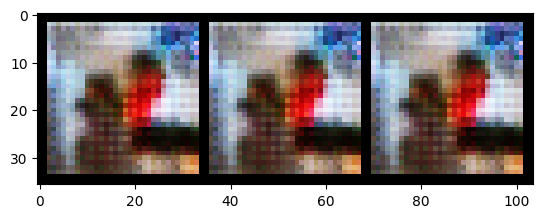

Epoch 82/100 (299s): G=0.288, Dr=0.079, Df=1.643
Epoch 83/100 (302s): G=0.254, Dr=0.100, Df=1.480
Epoch 84/100 (306s): G=0.307, Dr=0.103, Df=1.547
Epoch 85/100 (310s): G=0.296, Dr=0.071, Df=1.775
Epoch 86/100 (313s): G=0.272, Dr=0.068, Df=1.544


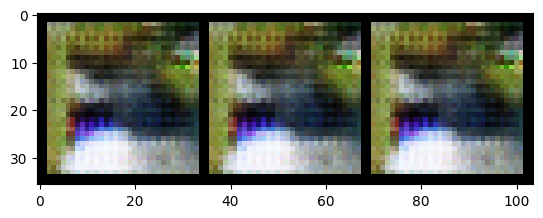

Epoch 87/100 (317s): G=0.294, Dr=0.072, Df=1.495
Epoch 88/100 (321s): G=0.307, Dr=0.054, Df=1.591
Epoch 89/100 (324s): G=0.259, Dr=0.085, Df=1.568
Epoch 90/100 (328s): G=0.290, Dr=0.079, Df=1.450
Epoch 91/100 (332s): G=0.264, Dr=0.101, Df=1.431


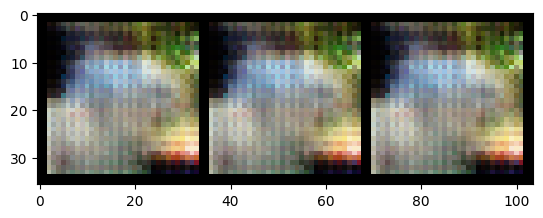

Epoch 92/100 (335s): G=0.267, Dr=0.095, Df=1.520
Epoch 93/100 (339s): G=0.274, Dr=0.199, Df=1.732
Epoch 94/100 (343s): G=0.333, Dr=0.099, Df=2.138
Epoch 95/100 (346s): G=0.320, Dr=0.094, Df=1.735
Epoch 96/100 (350s): G=0.303, Dr=0.065, Df=1.762


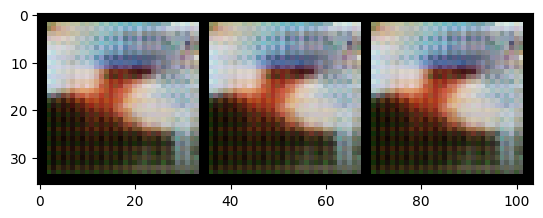

Epoch 97/100 (353s): G=0.285, Dr=0.073, Df=1.691
Epoch 98/100 (357s): G=0.283, Dr=0.088, Df=1.455
Epoch 99/100 (361s): G=0.257, Dr=0.135, Df=1.440
Epoch 100/100 (364s): G=0.288, Dr=0.079, Df=1.521


In [134]:
loss_g, loss_d_real, loss_d_fake = [], [], []
start = time()

BATCHES = len(train_dataset)//(2 * BATCH_SIZE)
discriminator_step = 2

for epoch in range(EPOCHS):
    loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
    for i in range(BATCHES):
        lg_ = gan.train_step_G()

        if i % discriminator_step == 0:
            ldr_, ldf_ = gan.train_step_D()
            loss_d_real_running += ldr_
            loss_d_fake_running += ldf_

        loss_g_running += lg_

    loss_g.append(loss_g_running / BATCHES)
    loss_d_real.append(loss_d_real_running * discriminator_step / BATCHES)
    loss_d_fake.append(loss_d_fake_running * discriminator_step / BATCHES)
    print(f"Epoch {epoch+1}/{EPOCHS} ({int(time() - start)}s):"
        f" G={loss_g[-1]:.3f},"
        f" Dr={loss_d_real[-1]:.3f},"
        f" Df={loss_d_fake[-1]:.3f}")
    if epoch % 5 == 0:
        visualize_GAN(gan)

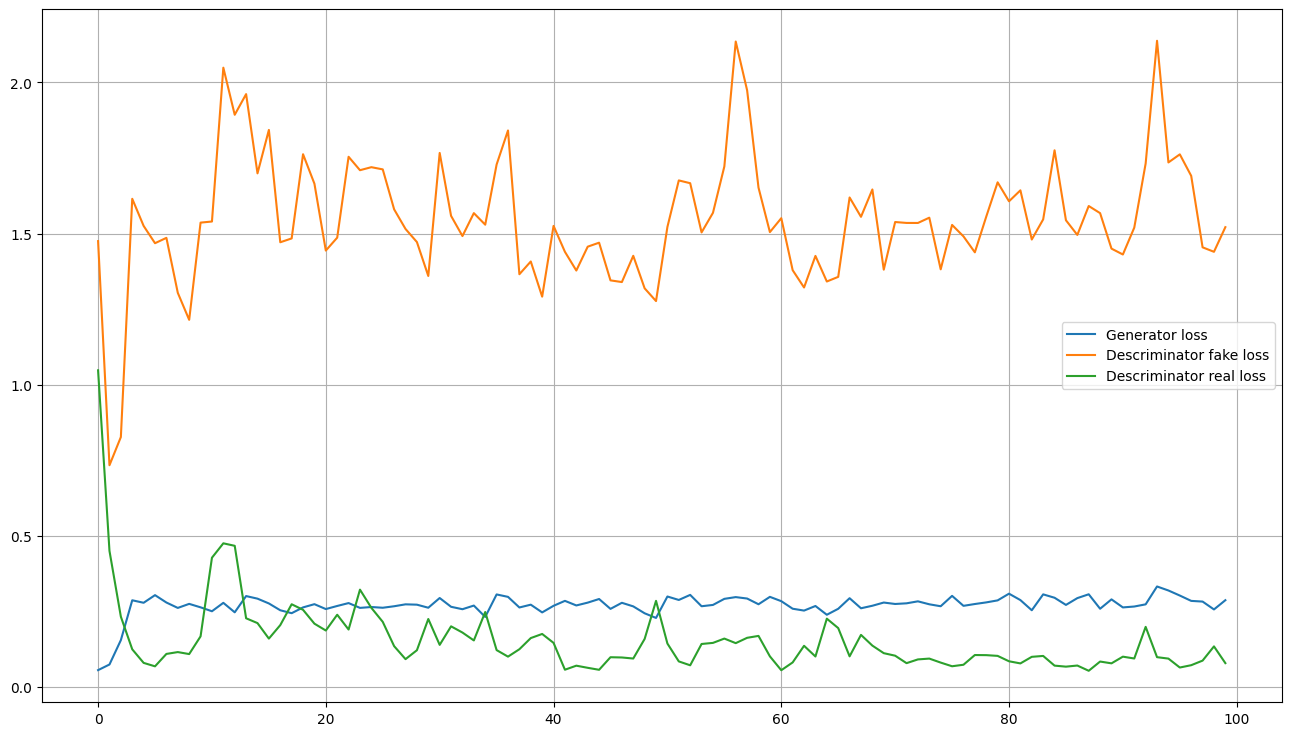

In [135]:
plt.figure(figsize=(16, 9))

plt.plot(np.arange(len(loss_g)), loss_g, label='Generator loss')
plt.plot(np.arange(len(loss_d_fake)), loss_d_fake, label='Descriminator fake loss')
plt.plot(np.arange(len(loss_d_real)), loss_d_real, label='Descriminator real loss')

plt.legend()
plt.grid()
plt.show()

### Результаты

Я варьировал количество блоков у генератора и дискрименатора. Все время происходит колапс (3 одинаковые картинки). В противовес пытался обучать дискриминатор в 2 раза меньше (в обучющем цикле пропускаем шаг с дискриминатором) и уменьшать количество блоков у дискриминатора.

Попробовал один раз сильно переобучить на более чем час. Модель сколапсировала в шум.

Добавил константу для регуляризации Dr и Df лоссов.

Сэмплы

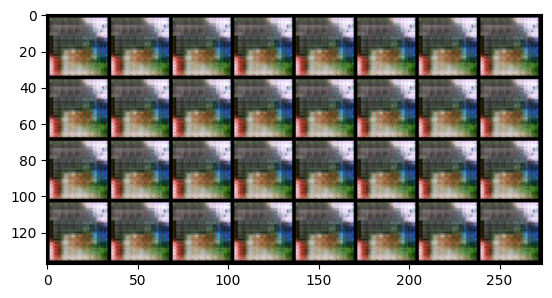

In [140]:
imshow(gan.generate_samples(32))

Интерполяция (видимо отсутсвует)

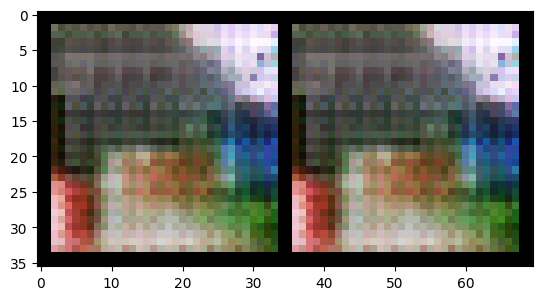

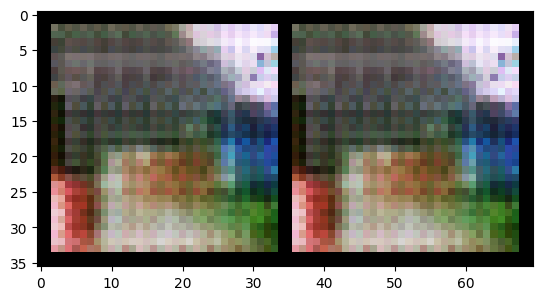

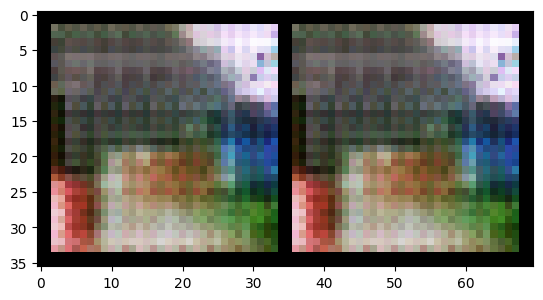

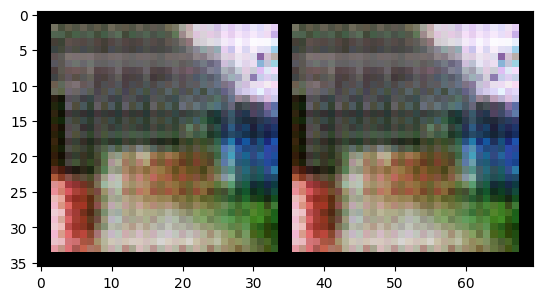

In [137]:
a = noise_fn(2)
b = torch.ones_like(a)
imshow(gan.generator(a)), 
imshow(gan.generator((2*a+b)/3))
imshow(gan.generator((a+b*2)/3))
imshow(gan.generator((a+b)/3))